In [1]:
import os
print(os.getcwd())
!ls

# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('/content/gdrive')

/content
sample_data
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


득점 X예측

In [31]:
import pandas as pd
import numpy as np
dt = pd.read_csv("/content/gdrive/My Drive/W_runs.csv")
pa = pd.read_csv("/content/gdrive/My Drive/PA_pred(2019).csv")
bf = pd.read_csv("/content/gdrive/My Drive/BF_pred(2019).csv")

dt['GDAY_DS']=dt['GDAY_DS'].astype(str)
dt['year'] = dt['GDAY_DS'].str.slice(0,4)
dt['mm'] = dt['GDAY_DS'].str.slice(4,6)
dt['dd'] = dt['GDAY_DS'].str.slice(6,8)
dt = dt.drop(['GDAY_DS'],axis=1)
dt = dt.query('year !="2020"')
dt = dt.sort_values(['year','mm','dd'])

In [32]:
pa_origin = pd.read_csv("/content/gdrive/My Drive/팀타자.csv")
bf_origin = pd.read_csv("/content/gdrive/My Drive/팀투수.csv")
pa_origin = pa_origin[['G_ID','T_ID','PA']]
bf_origin = bf_origin[['G_ID','T_ID','BF']]
col = dt.columns.to_list()
dt = dt.drop(['PA','BF'],axis=1)
dt = pd.merge(dt,pa_origin, on=['G_ID','T_ID'])
dt = pd.merge(dt,bf_origin, on=['G_ID','T_ID'])

In [33]:
schedule = pd.read_csv("/content/gdrive/My Drive/schedule.csv")

In [34]:
# items to be removed 
unwanted = {'year', 'VS_T_ID', 'dd', 'T_ID', 'G_ID', 'mm'}
col = [ele for ele in col if ele not in unwanted] 

In [65]:
def t_slice(team,pa_or_bf,us=True):

    idx = np.where(dt['year']=="2019")
    dt['year'].iloc[idx[0][:-188]] = '2019_1'
    dt['year'].iloc[idx[0][-188:]] = '2019_2'
    
    idx = np.where(dt['year']=="2018")
    dt['year'].iloc[idx[0][:-188]] = '2018_1'
    dt['year'].iloc[idx[0][-188:]] = '2018_2'

    if us:
        data = dt[dt['T_ID']==team]
    else:
        data = dt[dt['VS_T_ID']==team]

    tb = data.groupby(['year']).mean()
    tb = tb.div(tb[pa_or_bf],axis='rows')
    tb = tb[col]
    tb.loc['2019_2_pred'] =((tb.loc['2018_2']+tb.loc['2019_1'])/2).to_list()
    return(tb.loc['2019_2_pred'])

In [103]:
def pa_final(team_name):
    team_pa = pa[pa['T_ID']==team_name]
    team = pd.DataFrame()
    hit_to_pit = np.where(t_slice(team_name,'PA').index =='CG_CK')[0][0]
    for idx in t_slice(team_name,'PA').index[:hit_to_pit]:
        team[idx] = t_slice(team_name,'PA')[idx] * team_pa['PA'] 
    team = pd.concat([team_pa[['GDAY_DS','T_ID','VS_T_ID']], team], axis=1)
    return(team)

def bf_final(team_name):
    team_bf = bf[bf['T_ID']==team_name]
    team = pd.DataFrame()
    hit_to_pit = np.where(t_slice(team_name,'PA').index =='CG_CK')[0][0]
    for idx in t_slice(team_name,'PA').index[hit_to_pit:]:
        team[idx] = t_slice(team_name,'BF',False)[idx] * team_bf['BF']
    team = pd.concat([team_bf[['GDAY_DS','T_ID','VS_T_ID']], team], axis=1)
    return(team)

In [123]:
pa_final_df = pd.DataFrame()
bf_final_df = pd.DataFrame()
for team in dt['T_ID'].unique():
    pa_final_df = pd.concat([pa_final_df, pa_final(team)])
    bf_final_df = pd.concat([bf_final_df, bf_final(team)])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [135]:
HOME = bf_final_df['T_ID']
AWAY = bf_final_df['VS_T_ID']
bf_final_df.drop(['T_ID','VS_T_ID'],axis=1,inplace=True)
bf_final_df['T_ID'] = AWAY
bf_final_df['VS_T_ID'] = HOME

In [141]:
f = pd.merge(pa_final_df, bf_final_df, on=['T_ID','VS_T_ID','GDAY_DS'])

In [158]:
result = pd.concat([f.iloc[:125],f.iloc[127:146]])
result = pd.concat([result, f.iloc[148:]])

In [159]:
from google.colab import files
result.to_csv('W_runs_pred.csv')
files.download('W_runs_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ㅅ

In [207]:
pitcher= pd.read_csv("/content/gdrive/My Drive/pitcher_scaled_revised.csv")
hitter= pd.read_csv("/content/gdrive/My Drive/hitter_scaled.csv")

In [208]:
pitcher=pitcher.drop(['Unnamed: 0'],axis=1)
hitter=hitter.drop(['Unnamed: 0'],axis=1)

In [219]:
def t_slice2(df,team,pa_or_bf):

    idx = np.where(df['year']=="2019")
    df['year'].iloc[idx[0][:-188]] = '2019_1'
    df['year'].iloc[idx[0][-188:]] = '2019_2'
    
    idx = np.where(df['year']=="2018")
    df['year'].iloc[idx[0][:-188]] = '2018_1'
    df['year'].iloc[idx[0][-188:]] = '2018_2'
    data = df[df['T_ID']==team]
    tb = data.groupby(['year']).mean()
    tb = tb.div(tb[pa_or_bf],axis='rows')
    tb.loc['2019_2_pred'] =((tb.loc['2018_2']+tb.loc['2019_1'])/2).to_list()
    return(tb.loc['2019_2_pred'])

In [210]:
def date(df):
    df['GDAY_DS']= df['GDAY_DS'].astype(str)
    df['year'] = df['GDAY_DS'].str.slice(0,4)
    df['mm'] = df['GDAY_DS'].str.slice(4,6)
    df['dd'] = df['GDAY_DS'].str.slice(6,8)
    df = df.drop(['GDAY_DS'],axis=1)
    df = df.query('year !="2020"')
    df = df.sort_values(['year','mm','dd'])
    col = df.columns
    unwanted = {'mm', 'dd'}
    col = [ele for ele in col if ele not in unwanted] 
    return(df[col])

In [211]:
pitcher = date(pitcher)
hitter = date(hitter)

In [226]:
def pa_final2(team_name,data):
    team_pa = pa[pa['T_ID']==team_name]
    team = pd.DataFrame()
    for idx in t_slice2(data,team_name,'PA').index:
        team[idx] = t_slice2(data,team_name,'PA')[idx] * team_pa['PA'] 
    team = pd.concat([team_pa[['GDAY_DS','T_ID','VS_T_ID']], team], axis=1)
    return(team)

def bf_final2(team_name,data):
    team_bf = bf[bf['T_ID']==team_name]
    team = pd.DataFrame()
    for idx in t_slice2(data,team_name,'BF').index:
        team[idx] = t_slice2(data,team_name,'BF')[idx] * team_bf['BF']
    team = pd.concat([team_bf[['GDAY_DS','T_ID','VS_T_ID']], team], axis=1)
    return(team)

In [231]:
pa_final_df2 = pd.DataFrame()
bf_final_df2 = pd.DataFrame()
for team in dt['T_ID'].unique():
    pa_final_df2 = pd.concat([pa_final_df2, pa_final2(team,hitter)])
    bf_final_df2 = pd.concat([bf_final_df2, bf_final2(team,pitcher)])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [234]:
bf_final_df2.columns

Index(['GDAY_DS', 'T_ID', 'VS_T_ID', 'CG_CK', 'HOLD', 'INN2', 'BF', 'PA', 'AB',
       'HIT', 'H1', 'H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF', 'BB', 'IB', 'HP',
       'KK', 'GD', 'WP', 'BK', 'ERR', 'R', 'ER', 'P_WHIP_RT', 'P2_WHIP_RT',
       'CB_WHIP_RT', 'K/BB', 'OOPS', 'WHIP', 'BABIP', 'kFIP', 'HEADER_NO_1',
       'HEADER_NO_2', 'TB_SC_T'],
      dtype='object')

In [239]:
hitter_ERR=pa_final_df2[['GDAY_DS', 'T_ID','ERR']]
hitter_ERR.columns=['GDAY_DS', 'T_ID','Hitter_ERR']

bf_final_df2.columns=['GDAY_DS', 'T_ID', 'VS_T_ID', 'CG_CK', 'HOLD', 'INN2',
       'BF', 'PA', 'AB', 'HIT', 'H1', 'H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF',
       'BB', 'IB', 'HP', 'KK', 'GD', 'WP', 'BK', 'Pitcher_ERR', 'R', 'ER', 'P_WHIP_RT',
       'P2_WHIP_RT', 'CB_WHIP_RT', 'K/BB', 'OOPS', 'WHIP', 'BABIP', 'kFIP',
       'HEADER_NO_1', 'HEADER_NO_2', 'TB_SC_T']

In [241]:
f = pd.merge(bf_final_df2,hitter_ERR,on=['GDAY_DS','T_ID'])
result = pd.concat([f.iloc[:125],f.iloc[127:146]])
result = pd.concat([result, f.iloc[148:]])

In [242]:
f.to_csv('L_runs_pred.csv')
files.download('L_runs_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sfrom sklearn.metrics import mean_squared_error
from math import sqrt
a = (dt2['PA'] * tb_ratio['ERR'])
b = (dt2['ERR'])
sqrt(mean_squared_error(a, b))

0.13885337882661322

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
encoder.fit(dt['VS_T_ID'])
dt['VS_T_ID'] = encoder.transform(dt['VS_T_ID'])
dt = dt.drop(['G_ID','GDAY_DS','T_ID','HEADER_NO_1','HEADER_NO_2','TB_SC_T'], axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dt)
dt.iloc[:,:]=scaler.transform(dt)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = dt.drop(['PA'],axis=1)
y = dt['PA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [ ]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
rf.score(X_test,y_test)

0.767201514710532

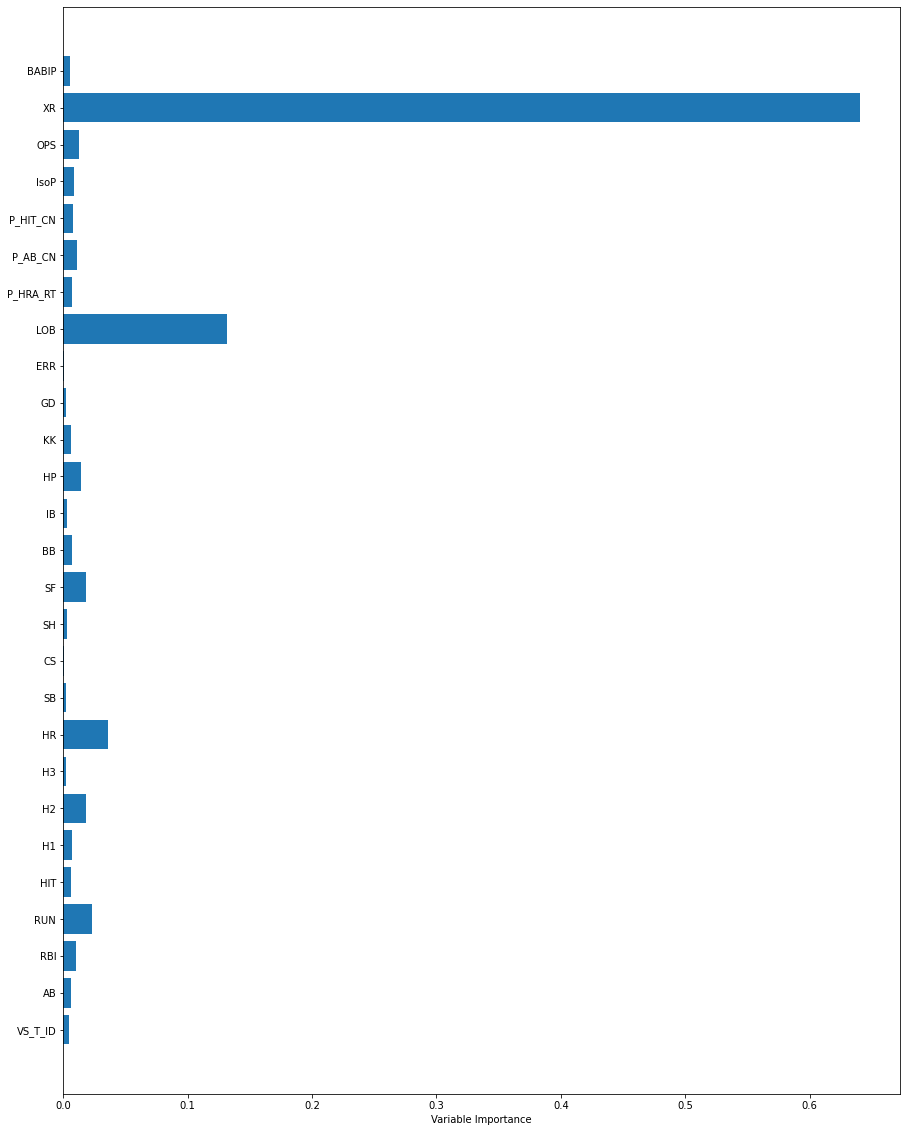

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 20))
ax.barh(X_test.columns, rf.feature_importances_)
ax.set_xlabel('Variable Importance')
plt.show()

In [ ]:
# Select: XR, LOB, HR, RUN
dt = dt[['PA','XR','LOB','HR','RUN']]
n_lag = 3
n_features = 5
n_seq = 3
n_test = 10

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = dt.values
n_obs = n_lag * n_features
plays = 500
reframed = series_to_supervised(dt, n_lag, n_seq)
reframed = pd.concat([reframed.iloc[:,:n_obs], reframed.iloc[:,[-3*n_features,-2*n_features,-1*n_features]]], axis=1)
values = reframed.values

In [ ]:
train, test = values[:plays,:], values[plays:,:]
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]

In [ ]:
test_X = test_X.reshape((test_X.shape[0], n_lag, 5))
train_X = train_X.reshape((train_X.shape[0], n_lag, 5))

In [ ]:
from keras.models import Sequential
import keras
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense

In [ ]:
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1,train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (1, 32)                   4864      
_________________________________________________________________
dense_8 (Dense)              (1, 3)                    99        
Total params: 4,963
Trainable params: 4,963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_X, train_y, epochs=20, batch_size=1, verbose=2, 
          validation_data=(test_X, test_y),shuffle=False)

Epoch 1/20
500/500 - 2s - loss: 0.0373 - val_loss: 0.0289
Epoch 2/20
500/500 - 1s - loss: 0.0239 - val_loss: 0.0280
Epoch 3/20
500/500 - 1s - loss: 0.0233 - val_loss: 0.0278
Epoch 4/20
500/500 - 1s - loss: 0.0232 - val_loss: 0.0277
Epoch 5/20
500/500 - 1s - loss: 0.0230 - val_loss: 0.0276
Epoch 6/20
500/500 - 1s - loss: 0.0229 - val_loss: 0.0275
Epoch 7/20
500/500 - 1s - loss: 0.0228 - val_loss: 0.0275
Epoch 8/20
500/500 - 1s - loss: 0.0228 - val_loss: 0.0274
Epoch 9/20
500/500 - 1s - loss: 0.0227 - val_loss: 0.0274
Epoch 10/20
500/500 - 1s - loss: 0.0226 - val_loss: 0.0274
Epoch 11/20
500/500 - 1s - loss: 0.0226 - val_loss: 0.0274
Epoch 12/20
500/500 - 1s - loss: 0.0225 - val_loss: 0.0274
Epoch 13/20
500/500 - 1s - loss: 0.0225 - val_loss: 0.0274
Epoch 14/20
500/500 - 1s - loss: 0.0225 - val_loss: 0.0274
Epoch 15/20
500/500 - 1s - loss: 0.0224 - val_loss: 0.0274
Epoch 16/20
500/500 - 1s - loss: 0.0224 - val_loss: 0.0274
Epoch 17/20
500/500 - 1s - loss: 0.0224 - val_loss: 0.0274
Epoch 

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (5, 3)                    108       
_________________________________________________________________
dense_7 (Dense)              (5, 3)                    12        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(test_X[-1:,:])

array([[0.4512531 , 0.46739733, 0.45816806]], dtype=float32)

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(500, 3, 5)
(500, 3)
(135, 3, 5)
(135, 3)


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (10, 3)                   108       
_________________________________________________________________
dense_2 (Dense)              (10, 3)                   12        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
